# Word Space Analysis

## load data

In [37]:
import pandas as pd, numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm

from datetime import datetime

In [2]:
df_word_space = pd.read_parquet("data/headlines/data_domestic_news_Jan_Feb.parquet")
df_word_space["date_collected"] = df_word_space.apply(lambda x : datetime.strptime(x["date_collected"][:8], "%Y%m%d"), axis = 1)

In [3]:
df_word_space

,url,headline,datePublished_site,probability,date_collected,siteName,NE,leaning
0,https://abcnews.go.com/International/surprise-...,Queen of Denmark says she will abdicate her th...,None,0.737869,2024-01-01,ABCNews(Online),[Denmark],left
1,https://abcnews.go.com/US/man-dies-shark-encou...,Man dies after shark encounter at Maui's Paia Bay,None,0.899625,2024-01-01,ABCNews(Online),"[Maui, Paia Bay]",left
2,https://abcnews.go.com/Sports/wireStory/report...,Former cycling world champ charged in wife's d...,None,0.934976,2024-01-01,ABCNews(Online),[],left
3,https://abcnews.go.com/US/wireStory/judge-allo...,Judge rejects NAACP request to bar new court,None,0.931576,2024-01-01,ABCNews(Online),[NAACP],left
4,https://abcnews.go.com/International/russia-la...,Russia launches drone assault after Ukraine at...,None,0.912954,2024-01-01,ABCNews(Online),"[Russia, Ukraine]",left
...,...,...,...,...,...,...,...,...
1177990,https://www.usatoday.com/story/news/world/2024...,New study says fish discovered 3 years ago can...,None,0.763477,2024-02-29,USATODAY,[],left
1177991,https://www.usatoday.com/story/entertainment/t...,"Black astronaut Ed Dwight, reflects on 'The Sp...",None,0.722521,2024-02-29,USATODAY,"[Black, Ed Dwight, The, Space Race]",left
1177992,https://www.usatoday.com/story/news/nation/202...,"'Life-threatening' conditions, up to 10 feet o...",None,0.685995,2024-02-29,USATODAY,[],left
1178008,https://www.usatoday.com/videos/news/politics/...,"Biden, Trump visit US-Mexico border on same day",None,0.448134,2024-02-29,USATODAY,"[Biden, Trump, US, Mexico]",left


In [4]:
from collections import Counter

NEs = [y for x in df_word_space["NE"] for y in x]

# Count the occurrence of each item
item_counts = Counter(NEs)
item_counts.most_common(50)


[('Trump', 15421),
 ('Biden', 8968),
 ('US', 8286),
 ('Taylor Swift', 4114),
 ('Super Bowl', 4085),
 ('Israel', 4020),
 ('Ukraine', 3655),
 ('Gaza', 3399),
 ('China', 2739),
 ('Russia', 2738),
 ('B', 2530),
 ('Iowa', 2462),
 ('Haley', 2427),
 ('Texas', 2278),
 ('GOP', 2193),
 ('Donald Trump', 2176),
 ('California', 2143),
 ('Hamas', 2100),
 ('Nikki Haley', 2056),
 ('Chiefs', 1974),
 ('NFL', 1970),
 ('NYC', 1968),
 ('Israeli', 1904),
 ('Republicans', 1832),
 ('Russian', 1815),
 ('Putin', 1793),
 ('U. S.', 1789),
 ('Travis Kelce', 1702),
 ('Republican', 1644),
 ('Senate', 1624),
 ('UK', 1615),
 ('Supreme Court', 1600),
 ('House', 1589),
 ('Iran', 1570),
 ('Florida', 1569),
 ('New Hampshire', 1536),
 ('America', 1474),
 ('AI', 1399),
 ('Michigan', 1338),
 ('White House', 1335),
 ('Democrats', 1335),
 ('New York', 1330),
 ('Americans', 1311),
 ('South Carolina', 1191),
 ('Congress', 1163),
 ('American', 1076),
 ('Japan', 1076),
 ('Fani Willis', 1055),
 ('Joe Biden', 1051),
 ('E', 997)]

## All Headline counting

In [11]:
df = pd.concat([pd.read_parquet("./data/headlines/raw/data_domestic_news_Jan.parquet"), pd.read_parquet("./data/headlines/raw/data_domestic_news_Feb.parquet")])
df["date_collected"] = df.apply(lambda x : datetime.strptime(x["date_collected"][:8], "%Y%m%d"), axis = 1)

In [30]:
df.memory_usage(deep=True).sum() / (1024 ** 2)

1117.6402568817139

In [14]:
file_path = './data/site_leanings.json'

with open(file_path, 'r') as file:
    site_leaning = json.load(file)

In [20]:
tqdm.pandas()

df["leaning"] = df.progress_apply(lambda x : site_leaning.get(x["siteName"], None), axis = 1)
df = df[[x is not None for x in df["leaning"]]]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394241/2394241 [00:24<00:00, 98639.59it/s]


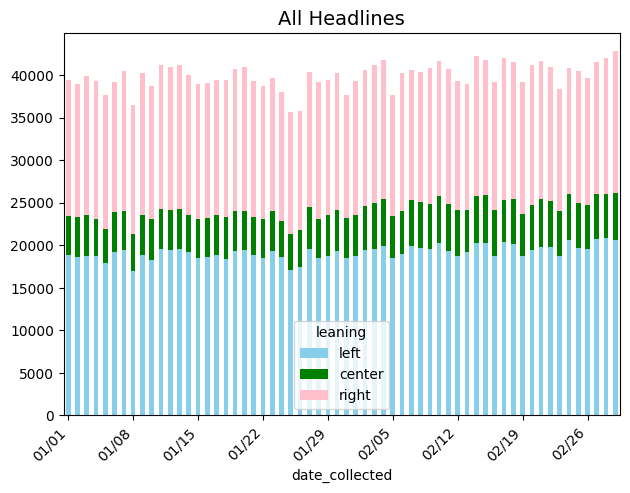

In [29]:
get_daily_trend(df, "All Headlines")

In [32]:
headline_num = df.groupby("date_collected")["date_collected"].value_counts()

In [40]:
mean = np.mean(list(headline_num))
sd = np.std(list(headline_num))

print(mean)
print(sd)

39893.416666666664
1496.3474228006748


## Unique headline counting

In [51]:
import csv

def read_csv(p):    
    # Initialize an empty list to store the rows of the CSV file
    data_list = []
    
    # Open the CSV file for reading
    with open(p, mode='r', encoding='utf-8') as file:
        # Create a CSV reader object
        csv_reader = csv.reader(file)
        
        # Iterate over each row in the CSV file
        for row in csv_reader:
            # Append each row (which is already a list) to the data_list
            data_list.append(row)

    return data_list
    
Biden_trend = read_csv("./data/biden_trend.csv")[3:]
Trump_trend = read_csv("./data/trump_trend.csv")[3:]

In [56]:
Biden_trend

[['2024-01-01', '19'],
 ['2024-01-02', '21'],
 ['2024-01-03', '26'],
 ['2024-01-04', '21'],
 ['2024-01-05', '25'],
 ['2024-01-06', '33'],
 ['2024-01-07', '19'],
 ['2024-01-08', '26'],
 ['2024-01-09', '18'],
 ['2024-01-10', '23'],
 ['2024-01-11', '19'],
 ['2024-01-12', '28'],
 ['2024-01-13', '20'],
 ['2024-01-14', '29'],
 ['2024-01-15', '28'],
 ['2024-01-16', '24'],
 ['2024-01-17', '26'],
 ['2024-01-18', '32'],
 ['2024-01-19', '33'],
 ['2024-01-20', '18'],
 ['2024-01-21', '27'],
 ['2024-01-22', '30'],
 ['2024-01-23', '28'],
 ['2024-01-24', '39'],
 ['2024-01-25', '34'],
 ['2024-01-26', '36'],
 ['2024-01-27', '36'],
 ['2024-01-28', '30'],
 ['2024-01-29', '35'],
 ['2024-01-30', '35'],
 ['2024-01-31', '30'],
 ['2024-02-01', '37'],
 ['2024-02-02', '42'],
 ['2024-02-03', '24'],
 ['2024-02-04', '29'],
 ['2024-02-05', '24'],
 ['2024-02-06', '35'],
 ['2024-02-07', '34'],
 ['2024-02-08', '38'],
 ['2024-02-09', '100'],
 ['2024-02-10', '48'],
 ['2024-02-11', '30'],
 ['2024-02-12', '45'],
 ['2024-02

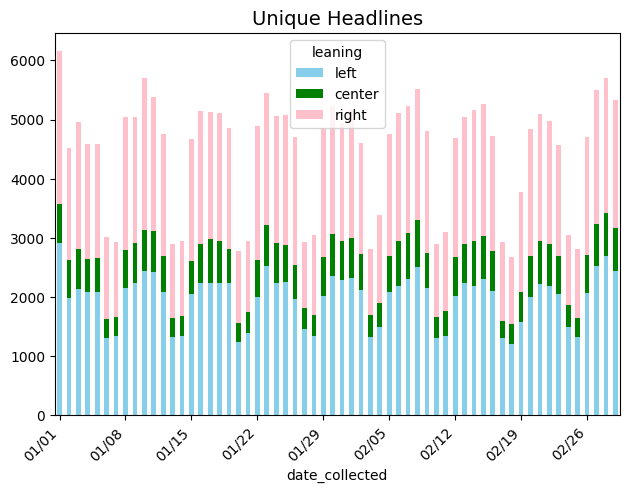

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20',
               '2024-01-21', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-27', '2024-01-28',
               '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01',
               '2024-02-02', '2024-02-03', '2024-02-04', '2024-02-05',
               '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09',
               '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13',
               '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-17',
               '2024-02-18', '2024-02-19', '2024-02-20', '2024-02-21',
               '2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25',
      

In [67]:
# Format the x-axis to display dates in 'YYYY-MM-DD' format, get x label
def get_daily_trend(df, title, trend = None):
    df_date_stats = df.groupby('date_collected')['leaning'].value_counts().unstack()
    df_date_stats = df_date_stats[["left", "center", "right"]]

    x_labels = [x.strftime('%m/%d') for x in df_date_stats.index[::7]] 
    ax = df_date_stats.plot(kind='bar', stacked=True, color=['skyblue', 'green', 'pink'])

    plt.gcf().autofmt_xdate()
    ax.set_xticks([x for x in range(0, 59, 7)])
    ax.set_xticklabels(x_labels, rotation=45)
    plt.tight_layout()
    plt.title(title, fontsize=14)

    # add trend 
    if trend is not None:
        ax2 = ax.twinx()  
        color = 'tab:blue'
        ax2.set_ylabel('Google Trend', color=color)
        # ax2.plot([x[0] for x in trend], [x[1] for x in trend], color=color, marker='s', label='Dataset 2')
        ax2.tick_params(axis='y', labelcolor=color)

        ax2.plot([x[0] for x in Biden_trend], [int(x[1]) for x in Biden_trend], label='Your Data Label')

    plt.show()
    return df_date_stats.index
    
get_daily_trend(df_word_space, "Unique Headlines")

In [65]:
def filter_df_by_NE(df, NE):
    filtered_df = df[df['NE'].apply(lambda x: len(set(x) & set(NE)) > 0)]
    return filtered_df

df_biden = filter_df_by_NE(df_word_space, ["Biden"])

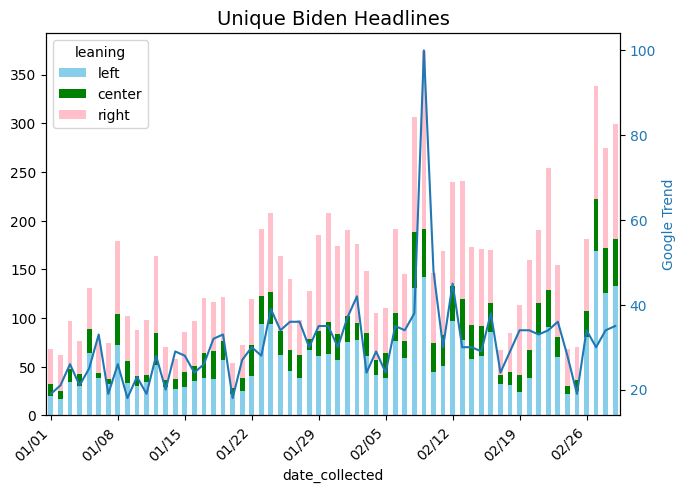

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20',
               '2024-01-21', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-27', '2024-01-28',
               '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01',
               '2024-02-02', '2024-02-03', '2024-02-04', '2024-02-05',
               '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09',
               '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13',
               '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-17',
               '2024-02-18', '2024-02-19', '2024-02-20', '2024-02-21',
               '2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25',
      

In [68]:
get_daily_trend(df_biden, "Unique Biden Headlines", Biden_trend)

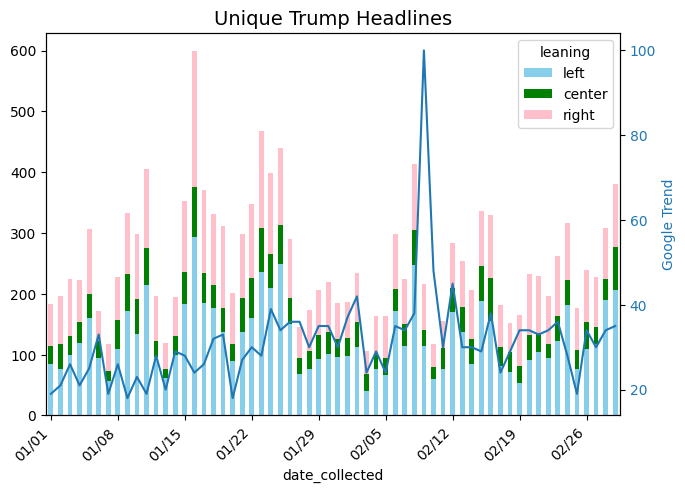

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20',
               '2024-01-21', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-27', '2024-01-28',
               '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01',
               '2024-02-02', '2024-02-03', '2024-02-04', '2024-02-05',
               '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09',
               '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13',
               '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-17',
               '2024-02-18', '2024-02-19', '2024-02-20', '2024-02-21',
               '2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25',
      

In [69]:
df_trump = filter_df_by_NE(df_word_space, ["Trump"])
get_daily_trend(df_trump, "Unique Trump Headlines", Trump_trend)

In [ ]:
# corrlationship between differnt side, how one side explain the other side
# descriptive stats of news coverage of both sides

In [161]:
file_path = './data/dem_rep_NEs.json'

with open(file_path, 'r') as file:
    dem_or_rep = json.load(file)

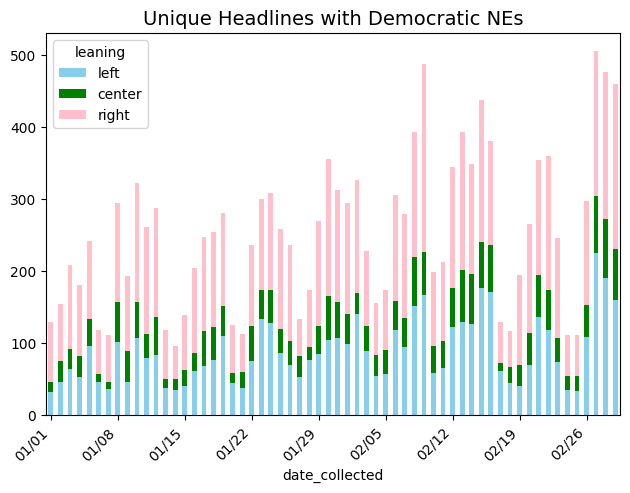

In [167]:
df_dem = filter_df_by_NE(df_word_space,dem_or_rep["Dem"])
get_daily_trend(df_dem, "Unique Headlines with Democratic NEs")

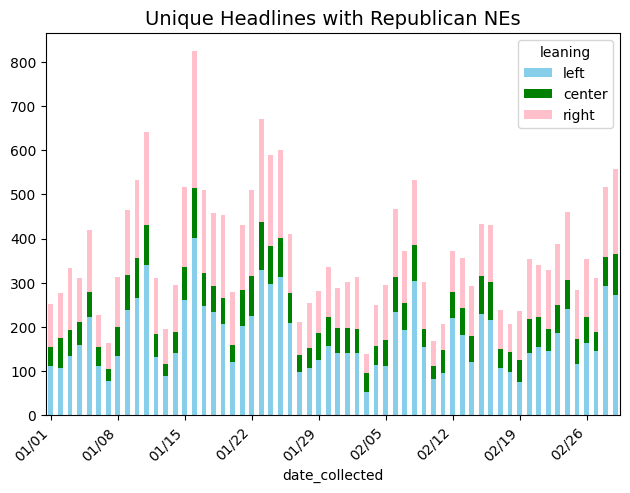

In [168]:
df_rep = filter_df_by_NE(df_word_space,dem_or_rep["Rep"])
get_daily_trend(df_rep, "Unique Headlines with Republican NEs")

# Word Space Visualization

In [42]:
df_word_space["leaning"].value_counts()

leaning
left      119065
right     113693
center     34878
Name: count, dtype: int64